In [93]:
# import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
import os

In [94]:
# define folder where your data is stored
directory = 'C:/D_disk/02_Learning/27_Ughent_courses/32_Master_dissertation/Git/Data'

# get all files in directory
all_files = os.listdir(directory)
all_files

['film_links_by_genre.csv', 'reviews_4000.csv', 'usernames.csv']

In [95]:
# read files
film = pd.read_csv('C:/D_disk/02_Learning/27_Ughent_courses/32_Master_dissertation/Git/Data/film_links_by_genre.csv')
reviews = pd.read_csv('C:/D_disk/02_Learning/27_Ughent_courses/32_Master_dissertation/Git/Data/reviews_4000.csv')

In [96]:
# clean reviews

# check reviews null value
print(reviews.isnull().sum())

# show
reviews.head(5)

user_id     0
film        0
comment    79
date        0
rating      0
dtype: int64


,user_id,film,comment,date,rating
0,/film_addiction/,quills,Watched this trash only because Joaquin Phoeni...,03 Sep 2024,★
1,/film_addiction/,children-of-divorce,This was the first Gary Coopers movie that I w...,25 Aug 2024,★★★★★
2,/film_addiction/,morocco,Spoilers !A classic without a doubt. Dietrich ...,25 Aug 2024,★★★
3,/film_addiction/,design-for-living,Absolutely loved this movie ! The humor and th...,25 Aug 2024,★★★★★
4,/dustymoth/,jfk,It was so long that I stopped caring who kille...,22 Oct 2024,★★


In [97]:
# Transfer reviews date time
# Check for out-of-bounds dates
invalid_dates = reviews[~reviews['date'].str.match(r'^\d{2} \w{3} \d{4}$')]

# Attempt to convert the 'date' column to datetime, while handling errors
reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')

# Check for rows with NaT (Not a Time) which indicates failed conversions
invalid_date_rows = reviews[reviews['date'].isna()]

# Optionally, drop or fill NaT values
reviews = reviews.dropna(subset=['date']) 


In [98]:
# Transfer the rating
# Define a function to convert star ratings to numerical values
def convert_rating(rating):
    # Remove any fractions from the ratings
    if '½' in rating:
        return (rating.count('★') + 0.5)  # Count stars and add 0.5 for half star
    return rating.count('★')  # Count stars

# Apply the conversion function to the 'rating' column
reviews['rating'] = reviews['rating'].apply(convert_rating)

In [99]:
reviews['rating'].value_counts()

rating
4.0    72297
3.0    54798
3.5    54568
5.0    50596
4.5    32442
0.0    29921
2.5    26416
2.0    23236
1.0    10208
1.5     9846
0.5     6175
Name: count, dtype: int64

In [100]:
# Cleaning the userid
reviews['user_id']=reviews['user_id'].str.replace('/','')

In [101]:
# Get unique user_id and film
user_film = reviews[['user_id','film']].drop_duplicates()

# Get the unique films and unique users
print('Unique users: ',len(user_film['user_id'].unique()))
print('Unique films: ',len(user_film['film'].unique()))

Unique users:  3747
Unique films:  61233


In [102]:
# Check the film number per user
film_per_user = user_film.groupby('user_id')['film'].count().reset_index()
film_per_user = film_per_user.rename(columns={'film':'Count'})
print('The max number film per user:', film_per_user['Count'].max())
print('The min number film per user:', film_per_user['Count'].min())
print('The average number film per user:', film_per_user['Count'].mean())
print('The median number film per user:', film_per_user['Count'].median())
print('The 25 percent number film per user:', film_per_user['Count'].quantile(0.25))
print('The 75 percent number film per user:', film_per_user['Count'].quantile(0.75))

The max number film per user: 156
The min number film per user: 1
The average number film per user: 91.8070456365092
The median number film per user: 115.0
The 25 percent number film per user: 65.0
The 75 percent number film per user: 120.0


{'whiskers': [<matplotlib.lines.Line2D at 0x231d20494f0>,
 'caps': [<matplotlib.lines.Line2D at 0x231d2049a30>,
 'boxes': [<matplotlib.lines.Line2D at 0x231d2049250>],
 'medians': [<matplotlib.lines.Line2D at 0x231d2049fa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x231d2054280>],
 'means': []}

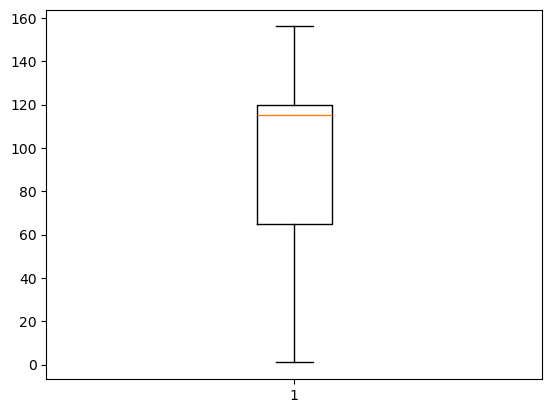

In [72]:
plt.boxplot(film_per_user['Count'])

Contamination: 0.1, Number of detected outliers: 369


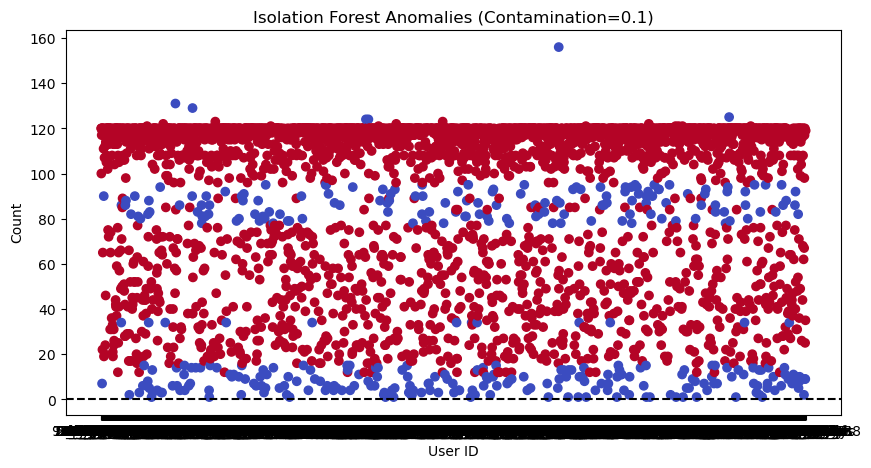

Contamination: 0.2, Number of detected outliers: 750


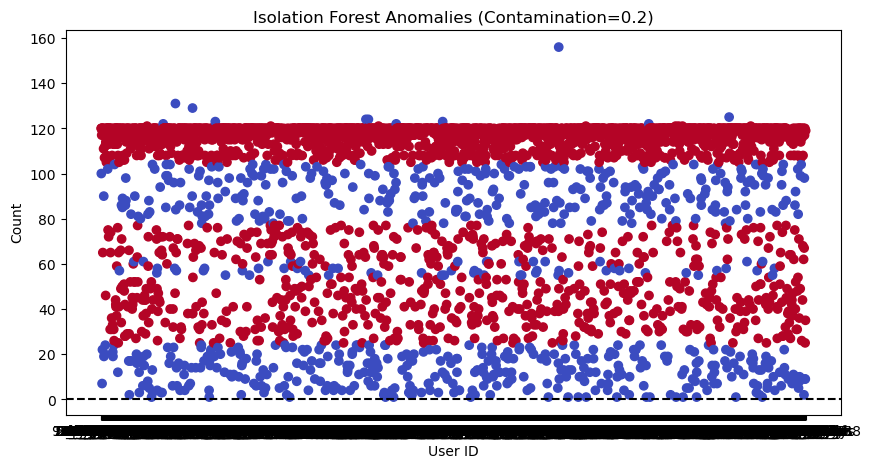

Contamination: 0.3, Number of detected outliers: 1111


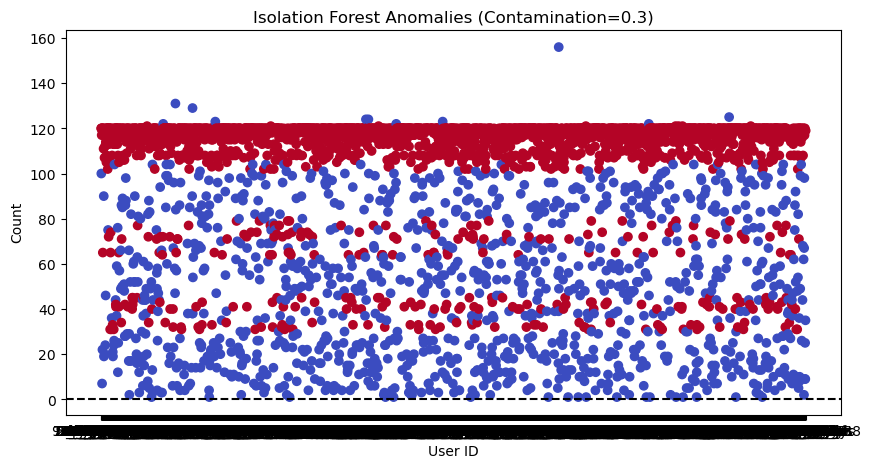

Contamination: 0.4, Number of detected outliers: 1470


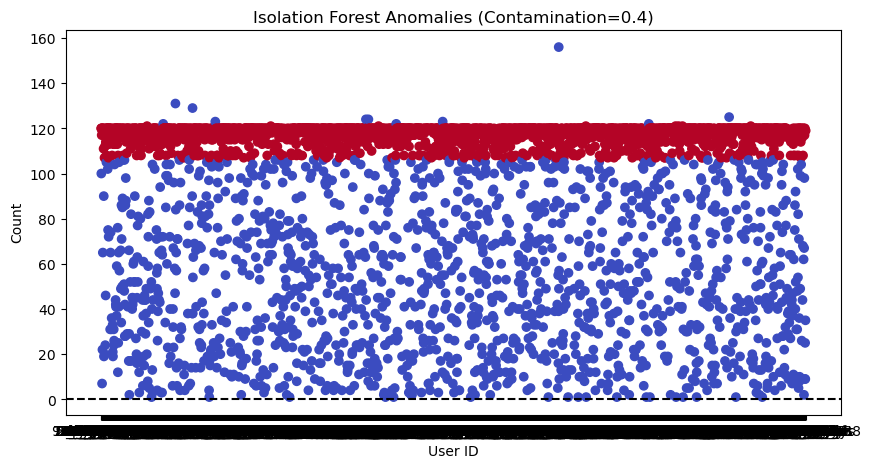

Contamination: 0.5, Number of detected outliers: 1830


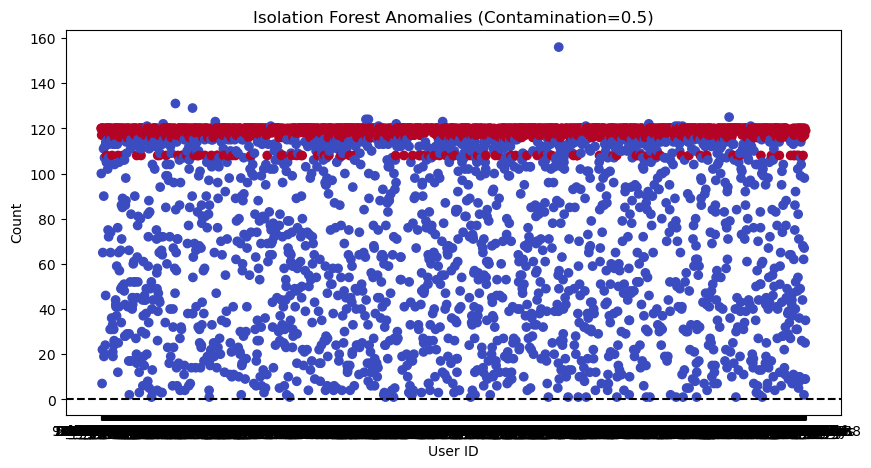

In [115]:
# Use insolation Forest to test outliers
contamination_levels = [0.1, 0.2,0.3,0.4,0.5]  

for contamination in contamination_levels:
    model = IsolationForest(contamination=contamination)
    film_per_user['anomaly'] = model.fit_predict(film_per_user[['Count']])
    
    # Step 3: Evaluate the results
    num_outliers = (film_per_user['anomaly'] == -1).sum()
    print(f"Contamination: {contamination}, Number of detected outliers: {num_outliers}")
    
    # Optional: Visualize anomalies
    plt.figure(figsize=(10, 5))
    plt.scatter(film_per_user['user_id'], film_per_user['Count'], c=film_per_user['anomaly'], cmap='coolwarm')
    plt.title(f'Isolation Forest Anomalies (Contamination={contamination})')
    plt.xlabel('User ID')
    plt.ylabel('Count')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.show()

Points labeled as 1 (inliers) usually appear in one color (e.g., blue).
Points labeled as -1 (outliers) will be in another color (e.g., red).

In [116]:
# Detect outliers
# Fit the model
model = IsolationForest(contamination=0.4)  # Adjust contamination based on expected outlier ratio
film_per_user['anomaly'] = model.fit_predict(film_per_user[['Count']])

# Identify outliers
outliers_user = film_per_user[film_per_user['anomaly'] == -1]
outliers_user = outliers_user.reset_index()[['user_id','Count']]
outliers_user.sort_values(by='Count')

,user_id,Count
1148,robinlange,1
227,carolmfranco,1
1006,nloeliipankek,1
1156,roocipher21,1
1232,sophiesalzman,1
...,...,...
544,huppert77,124
1298,thecjgh,125
189,brthrash,129
159,benschade,131


In [126]:
# Filter outliters from film_per_user
merged = film_per_user.merge(outliers_user, on=['user_id', 'Count'], how='left', indicator=True)
filtered_user_IF = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')

{'whiskers': [<matplotlib.lines.Line2D at 0x231856f2f10>,
 'caps': [<matplotlib.lines.Line2D at 0x231a202bf70>,
 'boxes': [<matplotlib.lines.Line2D at 0x23187935df0>],
 'medians': [<matplotlib.lines.Line2D at 0x231a201d3d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x23181ed4970>],
 'means': []}

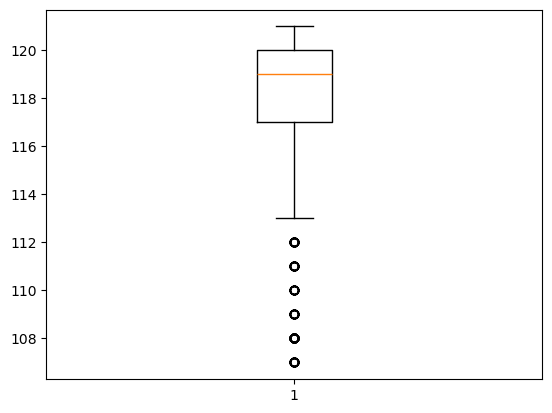

In [ ]:
plt.boxplot(filtered_user_IF['Count'])

In [73]:
# Check the user number per film
user_per_film = user_film.groupby('film')['user_id'].count().reset_index()
user_per_film = user_per_film.rename(columns={'user_id':'Count'})
print('The max number user per film:', user_per_film['Count'].max())
print('The min number user per film:', user_per_film['Count'].min())
print('The average number user per film:', user_per_film['Count'].mean())
print('The median number user per film:', user_per_film['Count'].median())
print('The 25 percent number user per film:', user_per_film['Count'].quantile(0.25))

The max number user per film: 1048
The min number user per film: 1
The average number user per film: 5.617902111606487
The median number user per film: 1.0
The 25 percent number user per film: 1.0


{'whiskers': [<matplotlib.lines.Line2D at 0x231d2080460>,
 'caps': [<matplotlib.lines.Line2D at 0x231d2080880>,
 'boxes': [<matplotlib.lines.Line2D at 0x231d20801c0>],
 'medians': [<matplotlib.lines.Line2D at 0x231d2080dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x231d208d0d0>],
 'means': []}

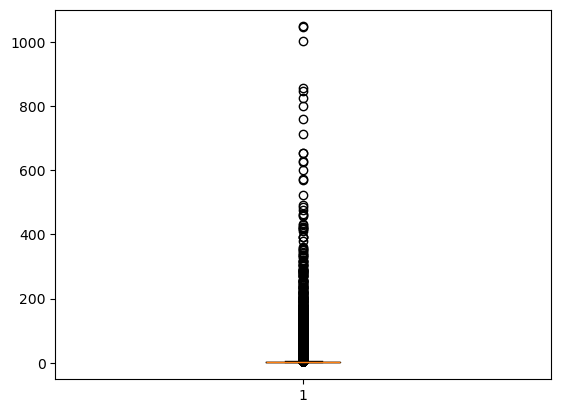

In [74]:
plt.boxplot(user_per_film['Count'])

Contamination: 0.1, Number of detected outliers: 5627


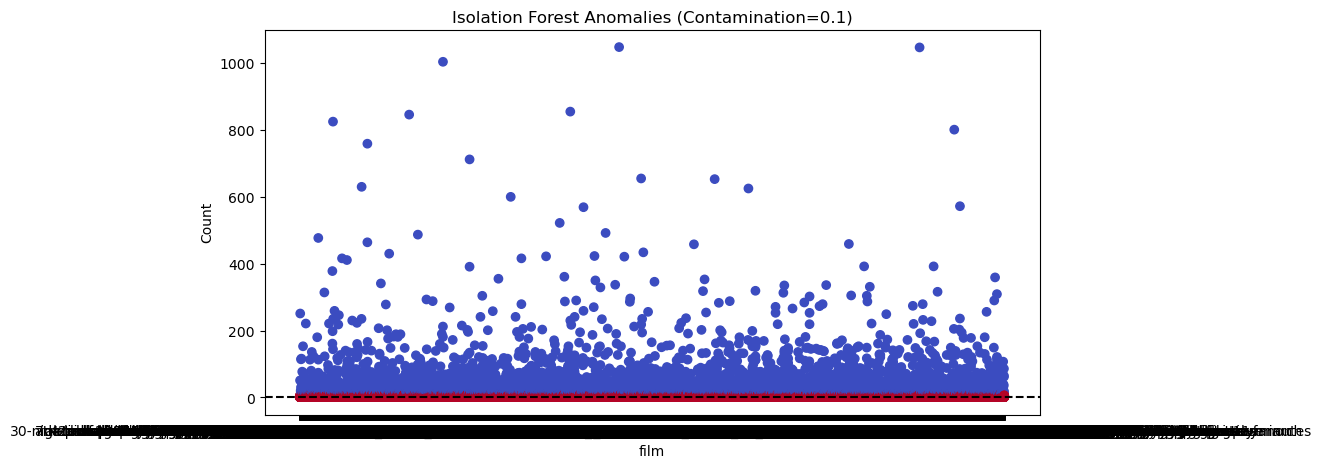

Contamination: 0.2, Number of detected outliers: 11397


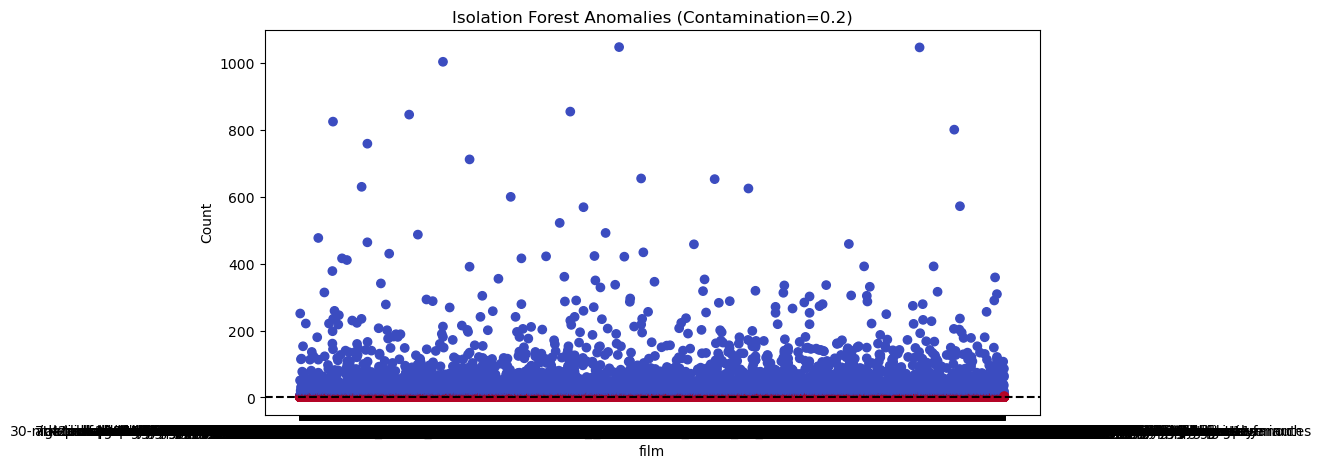

Contamination: 0.3, Number of detected outliers: 18078


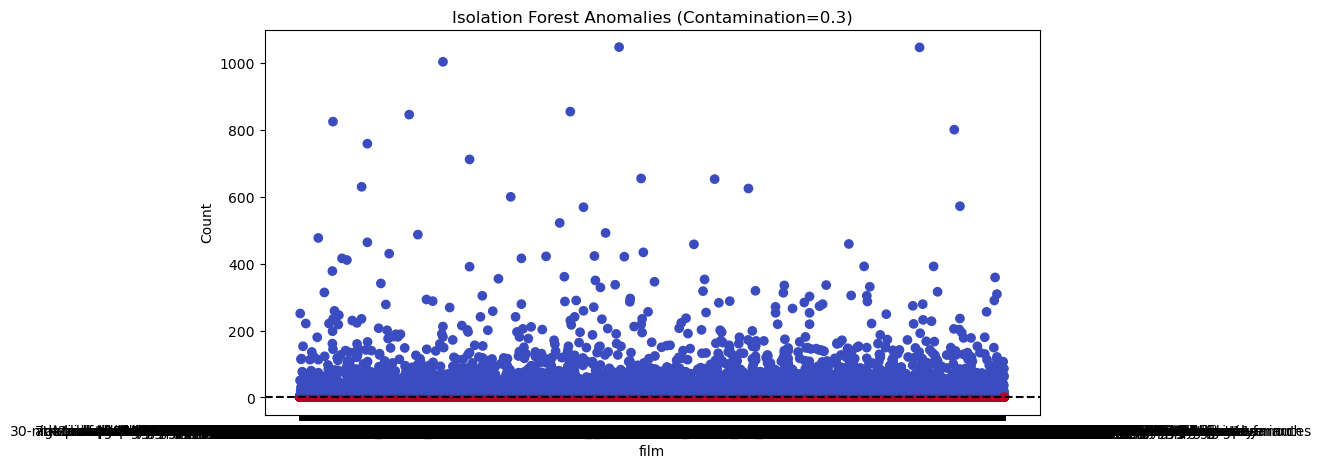

Contamination: 0.4, Number of detected outliers: 18078


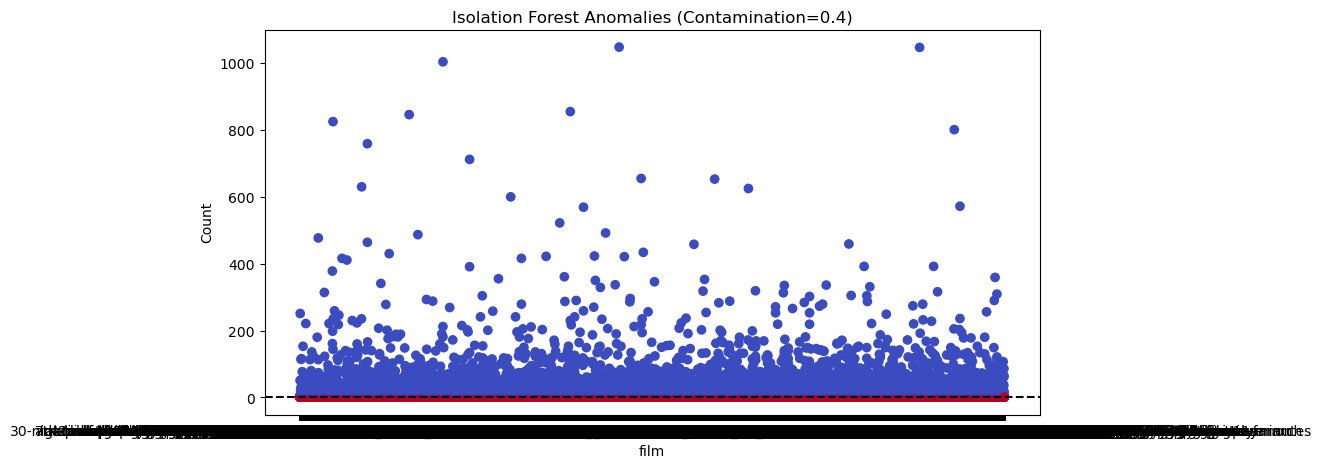

Contamination: 0.5, Number of detected outliers: 27080


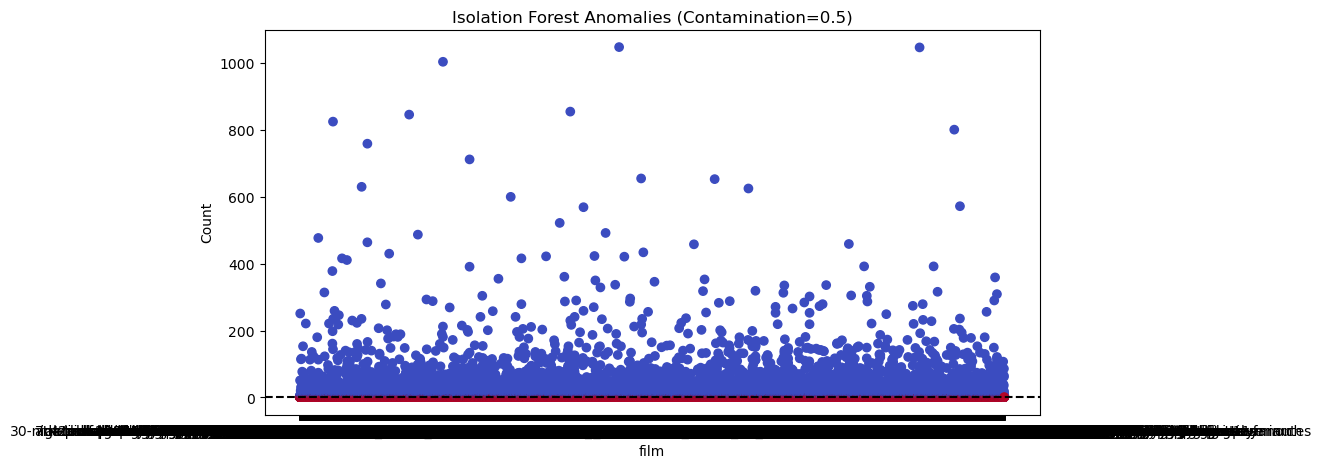

In [121]:
# Use insolation Forest to test outliers
contamination_levels = [0.1, 0.2,0.3,0.4,0.5]  

for contamination in contamination_levels:
    model = IsolationForest(contamination=contamination)
    user_per_film['anomaly'] = model.fit_predict(user_per_film[['Count']])
    
    # Step 3: Evaluate the results
    num_outliers = (user_per_film['anomaly'] == -1).sum()
    print(f"Contamination: {contamination}, Number of detected outliers: {num_outliers}")
    
    # Optional: Visualize anomalies
    plt.figure(figsize=(10, 5))
    plt.scatter(user_per_film['film'], user_per_film['Count'], c=user_per_film['anomaly'], cmap='coolwarm')
    plt.title(f'Isolation Forest Anomalies (Contamination={contamination})')
    plt.xlabel('film')
    plt.ylabel('Count')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.show()

In [129]:
# Detect outliers
# Fit the model
model = IsolationForest(contamination=0.5)  # Adjust contamination based on expected outlier ratio
user_per_film['anomaly'] = model.fit_predict(user_per_film[['Count']])

# Identify outliers
outliers_film = user_per_film[user_per_film['anomaly'] == -1]
outliers_film = outliers_film.reset_index()[['film','Count']]
outliers_film.sort_values(by='Count')

,film,Count
7183,faraway-2023,2
8497,gone-with-the-bullets,2
19739,the-batman-superman-movie-worlds-finest,2
19738,the-batman-part-ii,2
8500,gonin,2
...,...,...
4081,challengers,846
10318,inside-out-2-2024,855
5370,deadpool-wolverine,1004
23850,the-substance,1047


In [130]:
# Filter outliters from film_per_user
merged = user_per_film.merge(outliers_film, on=['film', 'Count'], how='left', indicator=True)
filtered_film_IF = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')

{'whiskers': [<matplotlib.lines.Line2D at 0x232580a7b80>,
 'caps': [<matplotlib.lines.Line2D at 0x23227696f70>,
 'boxes': [<matplotlib.lines.Line2D at 0x232580a78b0>],
 'medians': [<matplotlib.lines.Line2D at 0x2325809b490>],
 'fliers': [<matplotlib.lines.Line2D at 0x2325809b2e0>],
 'means': []}

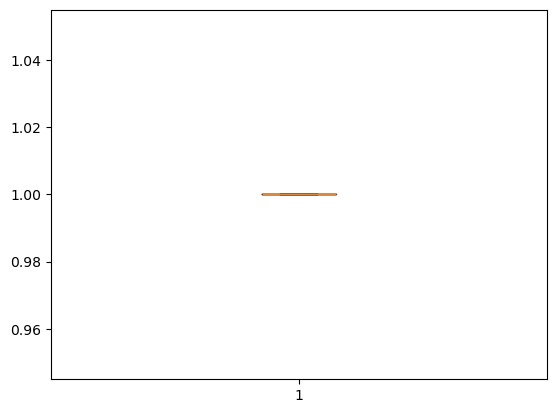

In [131]:
plt.boxplot(filtered_film_IF['Count'])

In [132]:
# Filter the number of user
filtered_user1 = film_per_user[film_per_user['Count']>=film_per_user['Count'].mean()]
filtered_user2 = filtered_user_IF

# Filter the number of film is less than 5
filtered_film1 = user_per_film[user_per_film['Count']>=user_per_film['Count'].mean()]
filtered_film2 = filtered_film_IF

print('original user:',film_per_user.shape[0],'filtered users by average:',filtered_user1.shape[0],'filtered users by IsolationForest:',filtered_user2.shape[0])
print('original user:',user_per_film.shape[0],'filtered users by average:',filtered_film1.shape[0],'filtered users by IsolationForest:',filtered_film2.shape[0])

original user: 3747 filtered users by average: 2498 filtered users by IsolationForest: 2277
original user: 61233 filtered users by average: 9638 filtered users by IsolationForest: 34153


In [134]:
# Define a funtion to calcualte the matrix 

def filtered_user_film_matrix(filtered_user,filtered_film):

    # merge the final table user-film-rating
    final_filtered_df = filtered_user.merge(reviews,how='left',on='user_id').merge(filtered_film,how='inner',on='film')
    final_filtered_df=final_filtered_df[['user_id','film','rating']]
    final_filtered_df = final_filtered_df.drop_duplicates()

    # Initialize separate LabelEncoders for user_id and Film
    user_encoder = LabelEncoder()
    film_encoder = LabelEncoder()

    # Encode the 'user_id' column
    final_filtered_df['user_id'] = user_encoder.fit_transform(final_filtered_df['user_id'])

    # Encode the 'Film' column
    final_filtered_df['Film'] = film_encoder.fit_transform(final_filtered_df['film'])

    # Create user-item matrix
    user_item_matrix = final_filtered_df.pivot_table(index='user_id', columns='film', values='rating', fill_value=0)

    # Calculate sparsity
    num_non_zero_entries = (user_item_matrix != 0).sum().sum()  # Count of non-zero entries
    total_entries = user_item_matrix.size  # Total entries in the matrix
    sparsity = 1 - (num_non_zero_entries / total_entries)  # Sparsity value
    sparsity_percentage = sparsity * 100  # Sparsity percentage

    print(f'Martix size:',final_filtered_df.shape)
    print(f"Sparsity: {sparsity:.4f}")
    print(f"Sparsity Percentage: {sparsity_percentage:.2f}%")
    return user_item_matrix
    

In [ ]:
# Check sparsity
df_avg = filtered_user_film_matrix(filtered_user1,filtered_film1)

Martix size: (215470, 4)
Sparsity: 0.9917
Sparsity Percentage: 99.17%


In [137]:
# Check sparsity
df_IF = filtered_user_film_matrix(filtered_user2,filtered_film2)

Martix size: (29640, 4)
Sparsity: 0.9996
Sparsity Percentage: 99.96%


Summary: 
- --> Both methods(1. fliter users and film by averge threshold and 2. isolation forest) have high sparsity (>99.9%)
- --> In next step, we will clustering the films first. Use the clasters as film to construct the user-item matrix.